In [1]:
import sys
import pathlib as pl
import shapely
import matplotlib.pyplot as plt
import numpy as np
import flopy

# set up path for loading streamutil
custom_python_path = pl.Path("../python").absolute()
assert custom_python_path.is_dir()
sys.path.append(str(custom_python_path))
import streamutil


Len segment:  6
Len segment:  11
Len segment:  21


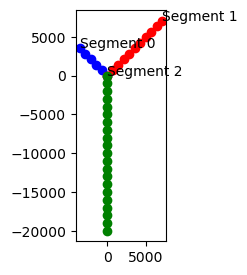

In [2]:

dxl = (5000 ** 2 / 2) ** 0.5
dxr = (10000 ** 2 / 2) ** 0.5
seg1 = [(-dxl, dxl), (0, 0)]
seg2 = [(dxr, dxr), (0, 0)]
seg3 = [(0, 0), (0, -20000)]
sgs = [seg1, seg2, seg3]
upstream_segments = [
    [],
    [],
    [0, 1]
]

# sgsd is the densified line segments ordered from upstream to downstream
reach_length = 1000.
sgsd = [
    streamutil.densify_geometry(sg, reach_length, keep_internal_nodes=False) for sg in sgs
]

fig = plt.figure(figsize=(2, 3))
ax = fig.add_subplot()
ax.set_aspect("equal")

line_symbols = ("bo-", "ro-", "go-", "yo-", "yo-", "bo-", "ro-")
for iseg, (sg, fmt) in enumerate(zip(sgsd, line_symbols)):
    print("Len segment: ", len(sg))
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], fmt)
    xstart, ystart = sg[0]
    ax.text(xstart, ystart, f"Segment {iseg}")

In [3]:
su = streamutil.StreamUtil(sgsd, upstream_segments)
sfr_reach_data = su.get_sfr_reachdata()

ia_seg2reach = su.ia_seg2reach
nsegments = su.nsegments
nreaches = su.nreaches
reach_connectivity = su.reach_connectivity
vertices, cell2d = su.get_vertices_cell2d()

print(f"{nsegments=}")
print(f"{nreaches=}")
print(f"{ia_seg2reach=}")
print(f"{reach_connectivity=}")
print(f"{vertices=}")
print(f"{cell2d=}")


nsegments=3
nreaches=35
ia_seg2reach=array([ 0,  5, 15, 35])
reach_connectivity=[[0, -1], [1, 0, -2], [2, 1, -3], [3, 2, -4], [4, 3, -15], [5, -6], [6, 5, -7], [7, 6, -8], [8, 7, -9], [9, 8, -10], [10, 9, -11], [11, 10, -12], [12, 11, -13], [13, 12, -14], [14, 13, -15], [15, 4, 14, -16], [16, 15, -17], [17, 16, -18], [18, 17, -19], [19, 18, -20], [20, 19, -21], [21, 20, -22], [22, 21, -23], [23, 22, -24], [24, 23, -25], [25, 24, -26], [26, 25, -27], [27, 26, -28], [28, 27, -29], [29, 28, -30], [30, 29, -31], [31, 30, -32], [32, 31, -33], [33, 32, -34], [34, 33]]
vertices=[(0, -3535.5339059327375, 3535.5339059327375, 0.0), (1, -2828.42712474619, 2828.42712474619, 0.0), (2, -2121.3203435596424, 2121.3203435596424, 0.0), (3, -1414.213562373095, 1414.213562373095, 0.0), (4, -707.1067811865473, 707.1067811865473, 0.0), (5, 0.0, 0.0, 0.0), (6, 7071.067811865475, 7071.067811865475, 0.0), (7, 6363.961030678927, 6363.961030678927, 0.0), (8, 5656.85424949238, 5656.85424949238, 0.0), (9, 4949.747

In [16]:
exe_name = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
sim_ws = "./beg2022b/mf6"
name = "swfmodel"
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    version="mf6", 
    exe_name=exe_name, 
    sim_ws=sim_ws,
    memory_print_option='all',
    continue_=True,
)

hr2sec = 60. * 60.
dt = 600 # seconds
perlen = 24 * hr2sec
nstp = perlen / dt
perioddata = [(0.0, 1, 1.0), (perlen, nstp, 1.0)]
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units="SECONDS",
    nper=len(perioddata),
    perioddata=perioddata
)
ims = flopy.mf6.ModflowIms(
    sim, 
    print_option="all", 
    linear_acceleration="BICGSTAB",
    outer_dvclose=1.e-4,
    inner_dvclose=1.e-4
)
swf = flopy.mf6.ModflowSwf(sim, modelname=name, save_flows=True)

nodes = nreaches
nvert = len(vertices)
slope = 1. / 10000.
z = np.zeros(nreaches, dtype=float)

disl = flopy.mf6.ModflowSwfdisl(
    swf, 
    nodes=nodes, 
    nvert=nvert,
    reach_length=reach_length,
    reach_bottom=z,
    idomain=1, 
    vertices=vertices, 
    cell2d=cell2d,
)

dfw = flopy.mf6.ModflowSwfdfw(
    swf, 
    central_in_space=True,
    print_flows=True,
    save_flows=True,
    width=40., 
    manningsn=1./80.,
    slope=slope,
    idcxs=0,
)

sto = flopy.mf6.ModflowSwfsto(
    swf,
    save_flows=True,
    steady_state={0: True, 1: False},
    transient={0: False, 1: True},
)

water_depth = 4.0
strt = z + water_depth
ic = flopy.mf6.ModflowSwfic(swf, strt=strt)

xfraction = np.array([0., 0., 10., 15., 25., 30., 40., 40.]) / 40.
height = [40., 10., 10., 0., 0., 10., 10., 40.]
npts = len(height)
mannfraction = npts * [1.]
cxsdata = list(zip(xfraction, height, mannfraction))
cxs = flopy.mf6.ModflowSwfcxs(
    swf,
    nsections=1,
    npoints=npts,
    packagedata=[(0, npts)],
    crosssectiondata=cxsdata,
)

# output control
oc = flopy.mf6.ModflowSwfoc(
    swf,
    budget_filerecord=f"{name}.bud",
    stage_filerecord=f"{name}.stage",
    saverecord=[("STAGE", "ALL"), ("BUDGET", "ALL"), ],
    printrecord=[("STAGE", "LAST"),("BUDGET", "ALL"), ],
)


# time, reach1 (cms)
reach_inflow = [
    (0, 20. / 2.),
    (2 * hr2sec, 20 / 2.),
    (3 * hr2sec, 25 / 2.),
    (4 * hr2sec, 20 / 2.),
    (24 * hr2sec, 20 / 2.),
]
flwlist = [
    [(0,), "reach1"],
    [(6,), "reach1"],
]
flw = flopy.mf6.ModflowSwfflw(
    swf,
    maxbound=len(flwlist),
    print_input=True,
    print_flows=True,
    stress_period_data=flwlist,
)
filename = name + ".flw.ts"
time_series_namerecord = [("reach1")]
interpolation_methodrecord = [("linearend")]
flw.ts.initialize(
    filename=filename,
    timeseries=reach_inflow,
    time_series_namerecord=time_series_namerecord,
    interpolation_methodrecord=interpolation_methodrecord,
)

chd = flopy.mf6.ModflowSwfchd(
    swf,
    maxbound=1,
    print_input=True,
    print_flows=True,
    stress_period_data=[(nreaches - 1, 4.)]
)

sim.write_simulation()
sim.run_simulation()



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model swfmodel...
    writing model name file...
    writing package disl...
    writing package dfw...
    writing package sto...
    writing package ic...
    writing package cxs...
    writing package oc...
    writing package flw_0...
    writing package ts_0...
    writing package chd_0...
FloPy is using the following executable to run the model: ../../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 07/13/2023
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec 13 2023 16:39:57 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received fin

(True, [])

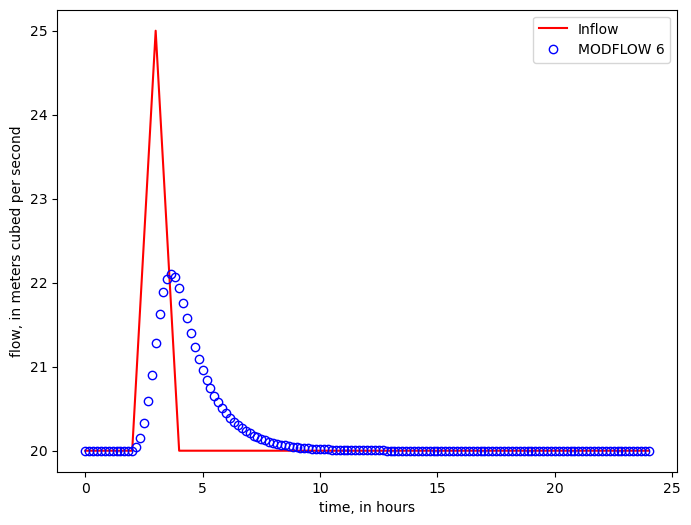

In [21]:
fpth = f"{sim_ws}/swfmodel.bud"
budobj = flopy.utils.binaryfile.CellBudgetFile(fpth, precision="double")
flowja = budobj.get_data(text="FLOW-JA-FACE")
qstorage = budobj.get_data(text="STORAGE")
qflw = budobj.get_data(text="FLW")
qchd = budobj.get_data(text="CHD")

qoutflow = []
times = np.array(budobj.times)
for ra in qchd:
    q = - ra[0]["q"]
    qoutflow.append(q)

qinflow = []
for ra in qflw:
    q = ra[:]["q"].sum()
    qinflow.append(q)


# plot upstream and downstream flow
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(times / 60. / 60., qinflow, 'r-', label="Inflow")
ax.plot(times / 60. / 60., qoutflow, 'bo', mfc="none", label="MODFLOW 6")
#ax.set_xlim(0, 10.)
#ax.set_ylim(19, 26)
plt.xlabel("time, in hours")
plt.ylabel("flow, in meters cubed per second")
plt.legend()
